## 自己复现单层神经网络模型的时候重要的几个参数是：
### _n_input, n_output, n_epoch, batch_size_
### _net_
### _loss_
### _optimizer_

In [70]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt
import sys
#sys.path.append("..")
import d2lzh_pytorch as d2l

In [71]:
x = torch.rand(2, 3, 2)
x

tensor([[[0.4802, 0.1982],
         [0.3789, 0.2697],
         [0.8087, 0.0857]],

        [[0.6706, 0.4312],
         [0.4543, 0.7635],
         [0.0871, 0.9152]]])

In [72]:
x.argmax(dim=0)

tensor([[1, 1],
        [1, 1],
        [0, 1]])

In [73]:
x.argmax(dim=1)

tensor([[2, 1],
        [0, 2]])

In [74]:
x.argmax(dim=2)

tensor([[0, 0, 0],
        [0, 1, 1]])

In [75]:
x = torch.tensor([[1. ,2., 3.], [1., 2., 3.]], requires_grad=True)
y = torch.pow(x, 2)
y.backward(torch.ones_like(y))
x, y, x.grad

(tensor([[1., 2., 3.],
         [1., 2., 3.]], requires_grad=True),
 tensor([[1., 4., 9.],
         [1., 4., 9.]], grad_fn=<PowBackward0>),
 tensor([[2., 4., 6.],
         [2., 4., 6.]]))

In [76]:
def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

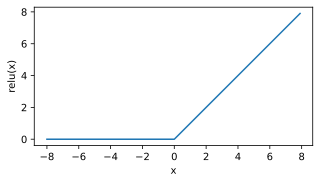

In [77]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

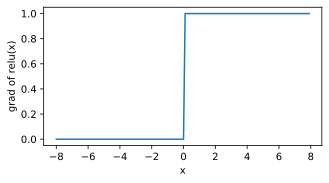

In [78]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

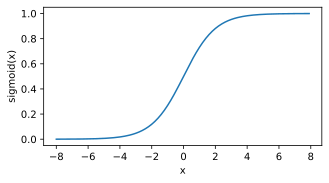

In [79]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

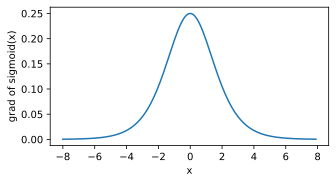

In [80]:
x.grad.zero_()#清除梯度
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

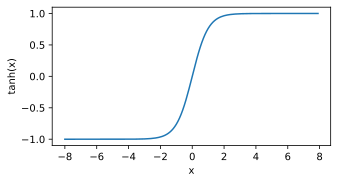

In [81]:
y = x.tanh()
xyplot(x, y, 'tanh')

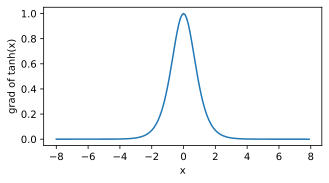

In [82]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

## 多项式拟合实验

In [83]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) # 张量按行拼接，其实就是3个输入
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b) # 标签y=1.2*x-3.4*x^2+5.6*x^3+5
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.8009],
         [-0.7652]]),
 tensor([[ 0.8009,  0.6414,  0.5136],
         [-0.7652,  0.5855, -0.4480]]),
 tensor([ 6.6479, -0.4167]))

In [84]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)


def fit_and_plot(train_features, test_features, train_labels, test_labels):
    num_epochs, loss = 100, torch.nn.MSELoss()
    net = torch.nn.Linear(train_features.shape[-1], 1)  # 其实相当于初始化一个随机的W（100*1）和b
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])  # 小批量
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 优化器，这里是用梯度下降
    train_ls, test_ls = [], []  # 记录的损失
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))  # net算出来的是估计值，与y值计算做损失值
            optimizer.zero_grad()  # 梯度清零
            l.backward()  # 计算梯度
            optimizer.step()  # 优化器更新
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features), train_labels).item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features), test_labels).item())  # 记录更新之后的net损失值
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,  # 输出权重和偏置
          '\nbias:', net.bias.data)


##### 正常拟合

final epoch: train loss 0.00010003943316405639 test loss 0.00017023984401021153
weight: tensor([[ 1.2079, -3.3979,  5.5976]]) 
bias: tensor([4.9996])


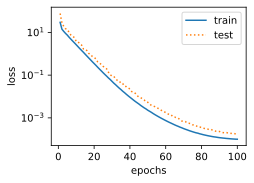

In [85]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

##### 欠拟合（非线性用线性模型训练）

final epoch: train loss 65.94734954833984 test loss 222.77601623535156
weight: tensor([[12.9023]]) 
bias: tensor([2.6501])


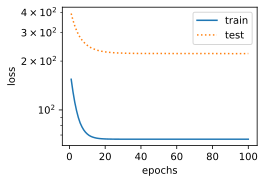

In [86]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

##### 过拟合（样本太小）

final epoch: train loss 0.4039875268936157 test loss 209.88937377929688
weight: tensor([[2.3904, 0.9981, 2.1317]]) 
bias: tensor([2.2046])


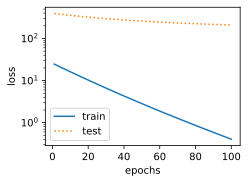

In [87]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

## 权重衰减
权重衰减等价于 L2范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段

## 高维线性回归实验

In [88]:
def l2_penalty(w):
    return (w**2).sum()/2

def init_params(num_inputs):
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def fit_and_plot2(train_features, test_features, train_labels, test_labels, lambd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    net, loss = d2l.linreg, d2l.squared_loss

    w, b = init_params(train_features.shape[-1])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_labels = train_labels.view(-1, 1)  # 训练的y
        test_labels = test_labels.view(-1, 1)  # 测试的y
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())  # 记录更新之后的net损失值
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())  # 记录更新之后的net损失值
    # print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',  # 画图
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight.norm:', w.norm().item())  # 输出权重L2范数
          # '\nbias:', b.item())

In [89]:
n_train, n_test, n_input = 20, 100, 200
true_w, true_b = torch.ones(n_input, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, n_input))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 增加干扰量
train_features, test_features = features[:n_train], features[n_train:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

#### 不使用权重衰减下的过拟合（因为这里刻意限制训练集大小）

weight.norm: 13.708962440490723


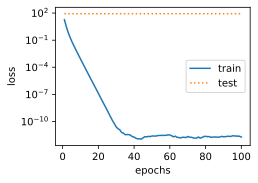

In [90]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 0)

#### 将lambd值逐渐调高，可见过拟合现象减弱，且权重的L2范数更加接近于0

weight.norm: 0.03572975471615791


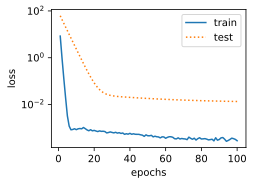

In [91]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 3)

weight.norm: 0.027745235711336136


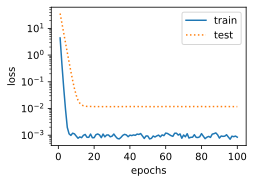

In [92]:
fit_and_plot2(train_features, test_features, train_labels, test_labels, 7)

### 用pytorch实现

In [93]:
def fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,wd):
    batch_size, num_epochs, lr = 1, 100, 0.003
    loss = torch.nn.MSELoss()
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = torch.nn.Linear(train_features.shape[-1], 1)
    torch.nn.init.normal_(net.weight, mean=0, std=1)
    torch.nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 其实就是把数据集丢到一个容器里
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # 相当于一个迭代器，每次抽取batch_size的数据
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())


L2 norm of w: 13.544088363647461


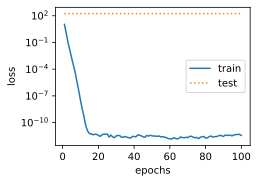

In [94]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,0)

L2 norm of w: 0.07158245146274567


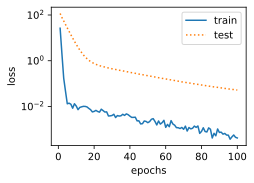

In [95]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,3)

L2 norm of w: 0.033885251730680466


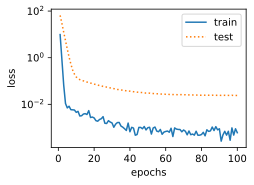

In [96]:
fit_and_plot_pytorch(train_features, test_features, train_labels, test_labels,7)

## Module 类

In [97]:
# 自己写的带两个隐藏层（hidden1 hidden2）和一个激活函数（act）的模型
class MLP(nn.Module):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.hidden1 = nn.Linear(784, 256) # 其实就是一个带可变参数的矩阵 有w和b
        self.act = nn.ReLU()
        self.hidden2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, X):
        return self.output(self.hidden2(self.act(self.hidden1(X))))

In [98]:
net = MLP()
x = torch.randn((10, 784))
net ,net(x)

(MLP(
   (hidden1): Linear(in_features=784, out_features=256, bias=True)
   (act): ReLU()
   (hidden2): Linear(in_features=256, out_features=128, bias=True)
   (output): Linear(in_features=128, out_features=10, bias=True)
 ),
 tensor([[ 0.1857,  0.0771, -0.1777,  0.1340,  0.2653,  0.2019, -0.1673,  0.0731,
           0.0027, -0.0337],
         [ 0.2349,  0.1504, -0.1134,  0.1264, -0.0154,  0.0908,  0.0329,  0.1540,
           0.0630,  0.0566],
         [ 0.1365,  0.1009, -0.0216,  0.1716,  0.1989,  0.0199, -0.0930, -0.1385,
           0.1391, -0.0156],
         [ 0.1616,  0.1623, -0.1700,  0.3125, -0.0820,  0.1073, -0.1053, -0.0524,
           0.1363,  0.0431],
         [ 0.1367,  0.0063, -0.1076,  0.1372,  0.0870,  0.1511, -0.2774, -0.2031,
           0.0773,  0.1126],
         [ 0.0374, -0.0704, -0.0536,  0.0641,  0.0962, -0.0748, -0.1679,  0.0865,
          -0.0932,  0.0565],
         [ 0.2133,  0.1238, -0.2684,  0.1269,  0.0413,  0.2045, -0.0361, -0.1612,
           0.0827,  0.1773

## 卷积

In [100]:
import d2lzh_pytorch
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
d2lzh_pytorch.corr2d(X, K)

AttributeError: module 'd2lzh_pytorch' has no attribute 'corr2d'